<a href="https://colab.research.google.com/github/paolomartine/Kaggle-udea-20251-Pruebas--saber-pro/blob/main/04_modelo_con_preprocesado_y_regresion_logistica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy entrenamiento: 0.3389729241877256
Accuracy test: 0.3396967509025271


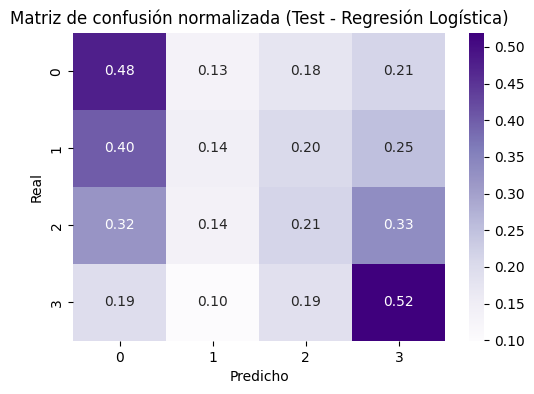

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [ ]:
# ----------------------------------------
# 1. IMPORTACIÓN DE LIBRERÍAS
# ----------------------------------------
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------------------
# 2. CARGA DE DATOS Y SELECCIÓN DE COLUMNAS
# ----------------------------------------
data = pd.read_csv('train.csv')
data = data[['FAMI_EDUCACIONPADRE', 'FAMI_ESTRATOVIVIENDA', 'RENDIMIENTO_GLOBAL']]

# ----------------------------------------
# 3. LIMPIEZA Y TRANSFORMACIÓN DE VARIABLES
# ----------------------------------------

# Rellenar valores nulos
data.FAMI_EDUCACIONPADRE.values[data.FAMI_EDUCACIONPADRE.isna()] = 'no info'
data.FAMI_ESTRATOVIVIENDA.values[data.FAMI_ESTRATOVIVIENDA.isna()] = 'no info'

# Mapear estratos
cmap = {
    'Estrato 1': 0.25, 'Estrato 2': 0.5, 'Estrato 3': 0.75,
    'Estrato 4': 1, 'Estrato 5': 1.25, 'Estrato 6': 1.5,
    'Sin Estrato': 0, 'no info': -1
}
data.FAMI_ESTRATOVIVIENDA = np.r_[[cmap[i] for i in data.FAMI_ESTRATOVIVIENDA]]

# Limpiar valores no informativos del padre
data.FAMI_EDUCACIONPADRE = ['no info' if i in ['No sabe', 'No Aplica'] else i for i in data.FAMI_EDUCACIONPADRE.values]

# One-hot encoding de FAMI_EDUCACIONPADRE
x = data.FAMI_EDUCACIONPADRE.values
FAMI_EDUCACIONPADRE_vals = sorted(np.unique(x))
FAMI_EDUCACIONPADRE_onehot_vals = {val: np.eye(len(FAMI_EDUCACIONPADRE_vals))[i] for i, val in enumerate(FAMI_EDUCACIONPADRE_vals)}
FAMI_EDUCACIONPADRE_onehot_enc = np.r_[[FAMI_EDUCACIONPADRE_onehot_vals[i] for i in data.FAMI_EDUCACIONPADRE]]

FAMI_EDUCACIONPADRE_df = pd.DataFrame(
    FAMI_EDUCACIONPADRE_onehot_enc,
    columns=[f"FAMI_EDUCACIONPADRE__{v}" for v in FAMI_EDUCACIONPADRE_onehot_vals]
)

data = pd.concat([FAMI_EDUCACIONPADRE_df, data], axis=1).drop('FAMI_EDUCACIONPADRE', axis=1)

# Mapear la variable objetivo
y_col = 'RENDIMIENTO_GLOBAL'
rmap = {'bajo': 0, 'medio-bajo': 1, 'medio-alto': 2, 'alto': 3}
rmapi = {v: k for k, v in rmap.items()}
data[y_col] = [rmap[i] for i in data[y_col]]

# Ordenar columnas
data = data[sorted(data.columns)]

# ----------------------------------------
# 4. DIVISIÓN EN VARIABLES INDEPENDIENTES Y DEPENDIENTE
# ----------------------------------------
X = data[[c for c in data.columns if c != y_col]].values
y = data[y_col].values

# ----------------------------------------
# 5. DIVISIÓN ENTRE TRAIN Y TEST
# ----------------------------------------
Xtr, Xts, ytr, yts = train_test_split(X, y, train_size=0.8, random_state=42)

# ----------------------------------------
# 6. ENTRENAMIENTO DEL MODELO
# ----------------------------------------
model = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
model.fit(Xtr, ytr)

# ----------------------------------------
# 7. EVALUACIÓN
# ----------------------------------------
preds_tr = model.predict(Xtr)
preds_ts = model.predict(Xts)

print("Accuracy entrenamiento:", np.mean(preds_tr == ytr))
print("Accuracy test:", np.mean(preds_ts == yts))

# Matriz de confusión normalizada
cm_ts = confusion_matrix(yts, preds_ts)
cm_ts = cm_ts / cm_ts.sum(axis=1, keepdims=True)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_ts, annot=True, cmap='Purples', fmt=".2f")
plt.title("Matriz de confusión normalizada (Test - Regresión Logística)")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()

# ----------------------------------------
# 8. PREDICCIÓN SOBRE TEST.CSV
# ----------------------------------------
zt = pd.read_csv('test.csv')
zt_ids = zt['ID'].values
zt = zt[['FAMI_EDUCACIONPADRE', 'FAMI_ESTRATOVIVIENDA']]

# Rellenar valores nulos
zt.FAMI_EDUCACIONPADRE.values[zt.FAMI_EDUCACIONPADRE.isna()] = 'no info'
zt.FAMI_ESTRATOVIVIENDA.values[zt.FAMI_ESTRATOVIVIENDA.isna()] = 'no info'

# Aplicar cmap
zt.FAMI_ESTRATOVIVIENDA = np.r_[[cmap[i] for i in zt.FAMI_ESTRATOVIVIENDA]]

# Limpiar y codificar FAMI_EDUCACIONPADRE
zt.FAMI_EDUCACIONPADRE = ['no info' if i in ['No sabe', 'No Aplica'] else i for i in zt.FAMI_EDUCACIONPADRE.values]
FAMI_EDUCACIONPADRE_onehot_enc = np.r_[[FAMI_EDUCACIONPADRE_onehot_vals[i] for i in zt.FAMI_EDUCACIONPADRE]]
FAMI_EDUCACIONPADRE_df = pd.DataFrame(FAMI_EDUCACIONPADRE_onehot_enc, columns=[f"FAMI_EDUCACIONPADRE__{v}" for v in FAMI_EDUCACIONPADRE_onehot_vals])

zt = pd.concat([FAMI_EDUCACIONPADRE_df, zt], axis=1).drop('FAMI_EDUCACIONPADRE', axis=1)

# Asegurar que tenga las mismas columnas que X
missing_cols = set(data.drop(y_col, axis=1).columns) - set(zt.columns)
for col in missing_cols:
    zt[col] = 0
zt = zt[data.drop(y_col, axis=1).columns]

# Predicción
preds_test_data = model.predict(zt)
text_preds_test_data = [rmapi[i] for i in preds_test_data]

# ----------------------------------------
# 9. SUBMISSION
# ----------------------------------------
submission = pd.DataFrame({'ID': zt_ids, 'RENDIMIENTO_GLOBAL': text_preds_test_data})
submission.to_csv("submission_logreg.csv", index=False)
